In [1]:
import numpy as np
import pandas as pd

### Things we need to fix from last installment:
* complete binary operators to include -, * and /
* make a better *grow method* that can cope with the new subclasses
* make mutate operate at the level of the entire tree
* modify the *evaluate method* to allow the use of arrays

### Recap: ConstLeafNode
```python
class ConstLeafNode(ExpressionTree):

    arity = 0 # leaf nodes have no children :-(

    def __init__(self,parent=None,**kwargs):
        v = kwargs.get('value',1.0)
        super().__init__(f'{v:0.2f}',parent)
        self._value = v

    def evaluate(self,data=None):
        if data is None:
            return self._value
        n = len(data)
        return np.repeat(self._value,n)

    def mutate(self):
        self._value = np.random.uniform(-1.0,1.0)
        self.name = f'{self._value:0.2f}'
```

### Recap: VarLeafNode
```python
class VarLeafNode(ExpressionTree):

    arity = 0 # leaf nodes have no children :-(

    def __init__(self,parent=None,**kwargs):
        self.varList = kwargs.get('varList',['x1'])
        v = np.random.choice(self.varList)
        super().__init__(v,parent)
        self.value = np.NaN

    def evaluate(self,data=None):
        if data is None:
            self.value = np.NaN
            return np.NaN
        else:
            self.value = data[self.name]
            return data[self.name]

    def mutate(self):
        v = np.random.choice(self.varList)
        self.name = v
```

### Recap: BinaryFuncPlus
```python
class BinaryFuncPlus(ExpressionTree):

    arity = 2 # v = left + right

    def __init__(self,parent=None,**kwargs):
        super().__init__('+',parent)
        self.value = np.NaN

    def evaluate(self,data=None):
        if data is None:
            self.value = np.NaN
            return np.NaN
        else:
            self.value = self.left.evaluate(data)+self.right.evaluate(data)
            return self.value

    def mutate(self):
        pass
```

### Other binary functions are exactly analogous to BinaryFuncPlus

The -, /, * functions have implemented in **TreeLib.py**

In [2]:
from mylib.TreeLib import *

TreeNode has loaded


In [3]:
c1 = ConstLeafNode(value=3.14)

In [4]:
v1 = VarLeafNode(varList=['x1','x2','x3'])

In [5]:
b1 = BinaryFuncMult()

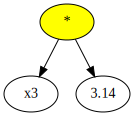

In [6]:
b1.left = v1
b1.right = c1
b1.plot()

Let's see how our class handles `DataFrame` input data. We assume this will always be numerical data.

In [7]:
x1 = [1,2,3,10]
x2 = [4,5,6,12]
x3 = [7,8,9,12]
data = pd.DataFrame({'x1':x1,'x2':x2,'x3':x3})

In [8]:
data

,x1,x2,x3
0,1,4,7
1,2,5,8
2,3,6,9
3,10,12,12


In [9]:
c1.evaluate(data)

array([3.14, 3.14, 3.14, 3.14])

In [10]:
v1.evaluate(data)

0     7
1     8
2     9
3    12
Name: x3, dtype: int64

In [11]:
b1.evaluate(data)

0    21.98
1    25.12
2    28.26
3    37.68
Name: x3, dtype: float64

In [12]:
b1.evaluate({'x3':13})

array([40.82])

### Note that for V1, the variable must exist in the data.

Probably should alter to return `NaN`.

In [13]:
v1.evaluate({'x3':13})

13

In [14]:
c1.evaluate({'x1':13})

array([3.14])

We see that we did not need to do anything special to make use of `DataFrame` data as Python itself is aware of vector and matrix operations.

### Make a better *grow method* that can cope with the new subclasses

We have implemented these changes in `ExpressionTree`

Classes 'know' about their own sub-classes, and this list is created dynamically.

In [15]:
from mylib.ExpressionTree import ExpressionTree as ET

In [16]:
[cls.__name__ for cls in ET.__subclasses__()]

['ConstLeafNode',
 'VarLeafNode',
 'BinaryFuncPlus',
 'BinaryFuncMinus',
 'BinaryFuncMult',
 'BinaryFuncDiv']

Let's try adding new subclass.

In [17]:
class BinaryFuncPow(ExpressionTree):
    
    arity = 2 # v = left ^ right
    
    def __init__(self,parent=None,**kwargs):
        super().__init__('^',parent)
        self.value = np.NaN
    
    def evaluate(self,data=None):
        if data is None:
            self.value = np.NaN
            return np.NaN
        else:
            self.value = np.power(self.left.evaluate(data),self.right.evaluate(data))
            return self.value
    
    def mutate(self):
        pass

In [18]:
[cls.__name__ for cls in ET.__subclasses__()]

['ConstLeafNode',
 'VarLeafNode',
 'BinaryFuncPlus',
 'BinaryFuncMinus',
 'BinaryFuncMult',
 'BinaryFuncDiv',
 'BinaryFuncPow']

We can even filter by arity:

In [19]:
[cls.__name__ for cls in ET.__subclasses__() if cls.arity==0]

['ConstLeafNode', 'VarLeafNode']

We can now design a function that can grow trees using arbitrary subclasses of `ExpressionTree`, we don't grow a new node if it already exists. The `maxd` parameter makes sure that growth will stop!

This is a good candidate for a `class method` and we will move it into the `ExpressionTree` class.

```python
@classmethod
def treegrow(cls,tree,maxd=5,varList=['x1','x2','x3']):
    d = tree.getDepth 
    if d < maxd and tree.arity > 0:
        if (d==maxd-1):
            if not tree.left:
                k = np.random.choice([k for k in cls.__subclasses__() if k.arity==0])
                tree.left = k(varList=varList)
        else:
            if not tree.left:
                k = np.random.choice([k for k in cls.__subclasses__()])
                tree.left = k()
            cls.treegrow(tree.left,maxd)
    if d < maxd and tree.arity > 1:
        if (d==maxd-1):
            if not tree.right:
                k = np.random.choice([k for k in cls.__subclasses__() if k.arity==0])
                tree.right = k(varList=varList)
        else:
            if not tree.right:
                k = np.random.choice([k for k in cls.__subclasses__()])
                tree.right = k()
            cls.treegrow(tree.right,maxd)
```

In [20]:
cls = np.random.choice([cls for cls in ET.__subclasses__() if cls.arity>0])
cls

__main__.BinaryFuncPow

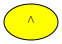

In [21]:
root = cls()
root.plot()

In [22]:
ET.treegrow(root,4)

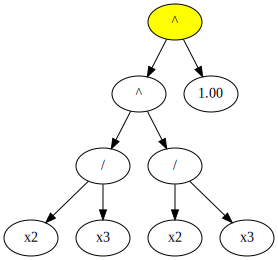

In [23]:
root.plot()

In [24]:
root.evaluate(data)

0    0.726308
1    0.745461
2    0.763143
3    1.000000
dtype: float64

In [25]:
ET.treegrow(root,4)

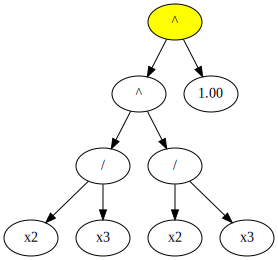

In [26]:
root.plot()

We have a very basic `ExpressionTree` class, and this completes the turorial.

Further work could use this as part of a *Genetic Programming* class which could be used to find algebraic expressions that model experimental data, perhaps a topic for a future tutorial. 